# Contributions to changing labor force participation

Brian Dew @bd_econ

Updated March 20, 2018

NOTE: CONTAINS ERRORS - NEED TO FILTER BASED ON [THIS](https://www.frbatlanta.org/chcs/human-capital-currents/2015/0612-measuring-labor-market-status-using-basic-data.aspx)

WILL REMOVE THIS NOTICE WHEN FIXED

In [1]:
# Import preliminaries and connect to CPS database
import pandas as pd
import numpy as np
import itertools

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)

In [2]:
# Parameters
age = (25, 54)
sex = ('Total', [1, 2])

In [3]:
# Demographic master file
y = 2001   # Base year
df = pd.read_feather(f'data/cps_{y}.ft', nthreads=3)
df = df[(df['PRTAGE'].between(16, 80)) & (df['HRMONTH'] == 3)]
aged = (df.groupby('PRTAGE')['PWSSWGT'].sum() / df['PWSSWGT'].sum()).to_dict()
sexd = (df.groupby('PESEX')['PWSSWGT'].sum() / df['PWSSWGT'].sum()).to_dict()
# Uncomment to demographically adjust by education (see below)
#educd = (df.groupby('PEEDUCA')['PWSSWGT'].sum() / df['PWSSWGT'].sum()).to_dict()

d = {}
for y in list(range(2000, 2019)):
    df = pd.read_feather(f'data/cps_{y}.ft', nthreads=3)
    for i, df in df.groupby('HRMONTH'):
        d1 = (df.groupby('PRTAGE')['PWSSWGT'].sum() / df['PWSSWGT'].sum()).to_dict()
        d[f'{y}-{i}_age'] = {k: float(aged[k])/d1[k] for k in d1.keys() & aged}
        d1 = (df.groupby('PESEX')['PWSSWGT'].sum() / df['PWSSWGT'].sum()).to_dict()
        d[f'{y}-{i}_sex'] = {k: float(sexd[k])/d1[k] for k in sexd}
        # Uncomment to demographically adjust by education (see below)
        #d1 = (df.groupby('PEEDUCA')['PWSSWGT'].sum() / df['PWSSWGT'].sum()).to_dict()
        #d[f'{y}-{i}_educ'] = {k: float(educd[k])/d1[k] for k in educd}

In [4]:
# Variables to adjust
ser = ['PWSSWGT', 'HRMONTH', 'PRTAGE', 'PESEX', 
       'PENLFACT', 'PEMLR', 'PEDWWNTO', 'PEEDUCA']
lfstat = [('Disabled/Ill', [6], 'PEMLR'),
          ('Discouraged', [1], 'PEDWWNTO'),          
          ('Enrolled in school', [3], 'PENLFACT'),
          ('Home/Family', [4], 'PENLFACT'), 
          ('Retired', [5], 'PEMLR'),
          ('LFPR', [1, 2, 3, 4], 'PEMLR')]

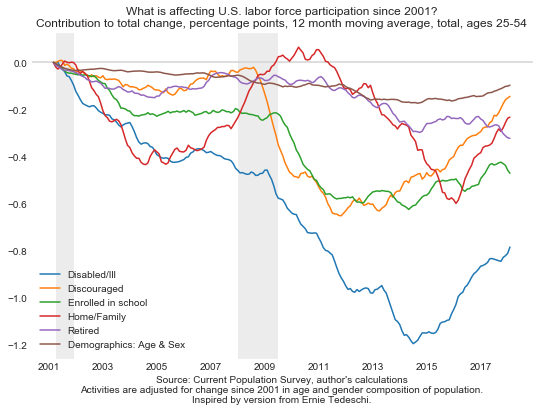

In [5]:
# Calculate age and sex adjusted values
df2 = pd.DataFrame()
df3 = pd.DataFrame()
for year in list(range(2000, 2019)):
    file = f'data/cps_{year}.ft'
    for i, df in pd.read_feather(file, nthreads=3)[ser].groupby('HRMONTH'):
        date = pd.to_datetime(f'{year}-{i}-01')
        d_key_age = f'{year}-{i}_age'
        dft = df[(df['PRTAGE'].between(age[0], age[1])) & 
                 (df['PEMLR'].isin(list(range(1,9)))) & 
                 (df['PESEX'].isin(sex[1]))]# & 
                # Uncomment to demographically adjust by education (see below)
                 #(df['PEEDUCA'].between(42, 46))]
        age_adj = dft['PRTAGE'].map(d[d_key_age])
        d_key_sex = f'{year}-{i}_sex'
        sex_adj = dft['PESEX'].map(d[d_key_sex])
        # Uncomment to demographically adjust by education (see below)
        #d_key_educ = f'{year}-{i}_educ'
        #educ_adj = dft['PEEDUCA'].map(d[d_key_educ])
        wgt = (age_adj * sex_adj) * dft['PWSSWGT']  # educ_adj
        #wgt = dft['PWSSWGT']
        gpop = wgt.sum()
        for lf in lfstat[:5]:
            if lf[0] in ['Discouraged', 'Retired', 'Disabled/Ill']:
                gtot = (np.where(dft[lf[2]].isin(lf[1]), 1, 0) * wgt).sum()
                df2.at[date, f'{lf[0]}'] = gtot / gpop * 100
            else:
                gtot = (np.where((dft[lf[2]].isin(lf[1])) & (dft['PEDWWNTO'] == 2), 1, 0) * wgt).sum()
                df2.at[date, f'{lf[0]}'] = gtot / gpop * 100                
        lfpr1 = (np.where(dft['PEMLR'].isin(lfstat[-1][1]), 1, 0) * wgt).sum() / gpop * 100 
        lfpr2 = (np.where(dft['PEMLR'].isin(lfstat[-1][1]), 1, 0) * dft['PWSSWGT']).sum() / dft['PWSSWGT'].sum() * 100
        # Extra calculations for seeing how demographics affect the (lfpr or epop) rate itself
        df2.at[date, 'Demographics: Age & Sex'] = lfpr1 - lfpr2 
        df3.at[date, 'LFPR_adj'] = lfpr1
        df3.at[date, 'LFPR_unadj'] = lfpr2
        epop = (np.where(dft['PEMLR'].isin([1, 2]), 1, 0) * wgt).sum() / gpop * 100
        df3.at[date, 'epop'] = epop
        
# Plot results
data2 = (df2.rolling(12).mean().loc['2001-03-01'] - df2.rolling(12).mean()).dropna()[3:]
title = (f'What is affecting U.S. labor force participation since 2001?\nContribution to total change, percentage points, 12 month moving average,'
         f' {sex[0].lower()}, ages {age[0]}-{age[1]}')
ax = data2.plot(figsize=(9, 6), title=title)
# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]
for i, v in rec_dt:
    ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.15)  
ax = plt.axhline(y=0, color='lightgray', zorder=1)
ax = plt.xlabel("Source: Current Population Survey, author's calculations\nActivities are adjusted for change since 2001 in age and gender composition of population.\nInspired by version from Ernie Tedeschi.")
plt.savefig(f'{sex[0]}{age[0]}{age[1]}.png', bbox_inches='tight', dpi=200)